# Load Raw Data And Compute MLDS

This script loads the database of the experiments described in
**"Response to Affine Transforms of Image Distance Metrics and Humans"**.

Then, it computes the MLDS curve for a particular imatge and particular distortion using stochastic gradient descent.

In [1]:
# Import libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import jax.numpy as jnp
from jax import grad, jit, vmap, random
import jax.scipy as jscipy


### MLDS function

In [2]:

def LL(x,psi,sig):
    # Inputs
    # x = [i,j,l,k,R], indexes of the images quadruplet and oberver response
    # psi = vector of MLDS parameters [1:number of distortions]
    # sig = standard deviation for the curve
    def LL_func(x):
        # Distance
        D = jnp.abs(psi[x[0]]-psi[x[1]])-jnp.abs(psi[x[2]]-psi[x[3]])

        # Probability
        pp = jscipy.stats.norm.cdf(D/sig)

        # Probability of '0' (p) or '1' (1-p)
        aa = (x[4]-pp) # (R-p)
        bb = ((-1)**(1+x[4])) # -1^(1+R)

        # LogLikelihood
        return jnp.log(aa*bb) # (1-p) if R==1, or p if R==0

    LLs = vmap(LL_func)(x)
    return LLs.sum()

### Gradient Step function

In [3]:

@jit
def mlds_step(batch, psi, sig):
    # Inputs
    # batch experiments to be used for the optimization [batch size x 5]
    # [N,i,j,l,k,R], indexes of the images quadruplet and oberver response
    # psi = vector of MLDS parameters [1:number of distortions]
    # sig = standard deviation for the curve

    # Derivatives
    DD = grad(LL,1)(batch,psi,sig)
    DDs = grad(LL,2)(batch,psi,sig)

    # Vanilla gradient step
    # First and last psi are not optimized
    psi = psi.at[1:-1].set(psi[1:-1] + lr*DD[1:-1])
    sig = sig + lr*DDs

    return psi, sig

### Load observers answers

In [4]:
url = 'https://raw.githubusercontent.com/paudauo/BBDD_Affine_Transformations/refs/heads/main/answers.csv'
BBDD = pd.read_csv(url,header=0)
print(BBDD.head(5))

  gender age_group transformation  image_id_01  distortion_level_11  \
0    man     41-50       rotation            1                    2   
1    man     41-50       rotation            1                    3   
2    man     41-50       rotation            1                    4   
3    man     41-50       rotation            1                    6   
4    man     41-50       rotation            2                    3   

   distortion_level_12  distortion_level_21  distortion_level_22  \
0                    1                    4                    6   
1                    2                   10                    4   
2                    3                    6                    8   
3                    3                    1                    2   
4                    5                    9                    8   

   reaction_time_ms  answer  
0              3335       2  
1              3936       2  
2              5875       2  
3              3143       1  
4             

### Prepare the data and parameters

In [5]:
# Choose the distortion and the image for the curve
im_ref = 1  # Reference Image (1,...,24)
transf = ['gaussian_noise'] # Posible Distortions: (['rotation'] ['translation'] ['scale'] ['gaussian_noise'])

# Learning Hyperparameters

Nimages = 10 # Number of distortion levels
sig = 0.1 # starting sigma
Np = 5000 # Number of gradient steps
BS = 20 # Batch Size
lr = 0.0001 # Learning rate
cada = 10 # Print results every 'cada'
seed = random.PRNGKey(40) # Seed for the data permutation

# Load the specific experiment

BBDD = BBDD[BBDD['image_id_01'] == im_ref]
BBDD = BBDD[BBDD['transformation'].isin(transf)]

# Extract experiments for the selected image and distortion

exp = BBDD[['distortion_level_11','distortion_level_12','distortion_level_21','distortion_level_22','answer']].values

exp = exp-1 # For adapting to python index format
exp = exp.astype('int')

### Perform the gradient descent optimization

In [6]:

# Convert to jnp array
exps =[]
for i in exp:
    a = list(map(int,i))
    exps.append(a)

exps = jnp.array(exps)

# Initializaing MLDS parameters
psi = jnp.linspace(0,1,Nimages)
best_psi = jnp.linspace(0,1,Nimages)
best_sig = sig

# LogLikelihood evolution
LLs = []

# gradient descent loop
for ii in range(Np):
    # Select batch
    batch_idxs = random.permutation(seed, jnp.arange(0,exps.shape[0]))[0:BS]
    seed, _ = random.split(seed)
    batch = exps[batch_idxs]

    # Gradient step (this is the key line)
    psi, sig = mlds_step(batch, psi, sig)

    # Save and visualize optimization evolution
    LLs.append(jit(LL)(exps, psi, sig))

    if jnp.mod(ii,cada)==0:
        print(ii,LLs[ii],jnp.round(sig,3))

    if jnp.isnan(LLs[ii]):
        break

0 -530.6827 0.113000005
10 -327.55756 0.19600001
20 -297.1808 0.23
30 -284.7599 0.254
40 -278.75476 0.266
50 -274.9865 0.272
60 -272.86298 0.273
70 -269.76813 0.28
80 -265.92166 0.287
90 -263.3159 0.291
100 -261.51865 0.29500002
110 -259.34937 0.30400002
120 -257.18625 0.30900002
130 -255.20348 0.31500003
140 -253.47551 0.321
150 -252.40587 0.32700002
160 -251.58272 0.32900003
170 -250.68996 0.33200002
180 -249.97043 0.33
190 -248.8805 0.33100003
200 -248.26291 0.33200002
210 -247.69061 0.33200002
220 -246.81198 0.337
230 -246.1947 0.33900002
240 -245.66208 0.34100002
250 -244.68988 0.342
260 -244.14114 0.34100002
270 -243.51096 0.34500003
280 -242.86581 0.349
290 -242.28946 0.349
300 -241.88136 0.347
310 -241.58366 0.347
320 -241.1395 0.347
330 -240.61217 0.35000002
340 -240.0346 0.351
350 -239.69896 0.354
360 -239.41689 0.35300002
370 -238.97177 0.351
380 -238.52911 0.35200003
390 -238.13437 0.34800002
400 -237.81563 0.34600002
410 -237.48112 0.34500003
420 -237.09906 0.34300002
430 

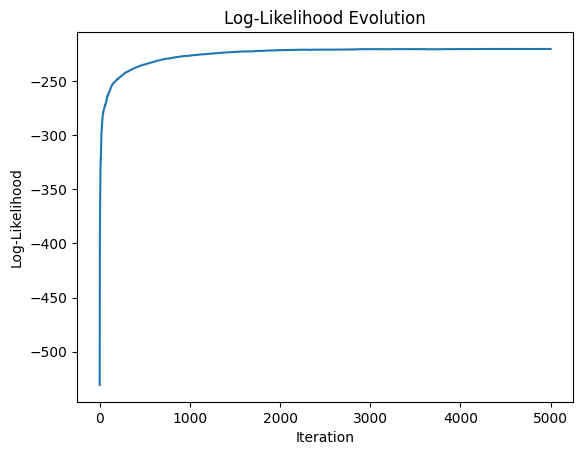

In [7]:
# Loglikelihood optimization evolution

plt.plot(LLs)
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.title("Log-Likelihood Evolution")
plt.show()


Text(0, 0.5, 'Difference scale')

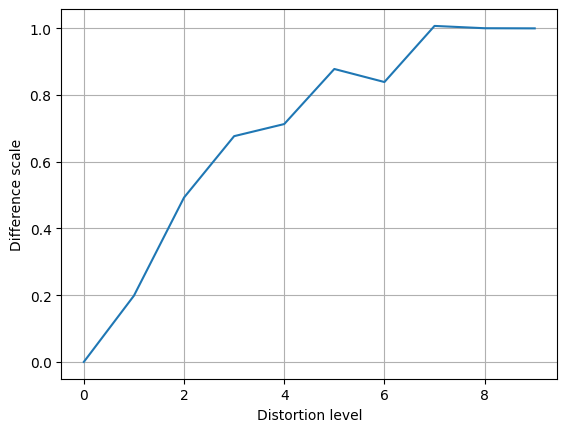

In [ ]:
# Plot the computed MLSD Perceptual Scale

xxx = np.linspace(0,psi.shape[0]-1,psi.shape[0])
plt.plot(xxx,psi)
plt.grid()

plt.xlabel('Distortion level')
plt.ylabel('Difference scale')

Text(0, 0.5, 'Perceptual scale')

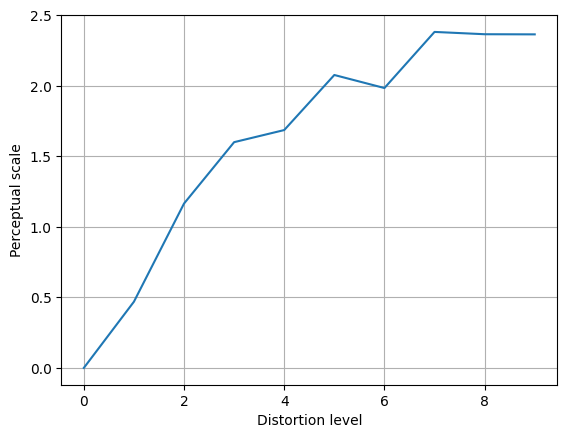

In [9]:
# Plot the computed MLSD response Normalized by sigma

SIGS = sig*np.ones(*psi.shape)
xxx = np.linspace(0,psi.shape[0]-1,psi.shape[0])
plt.plot(xxx,psi/SIGS)
plt.grid()

plt.xlabel('Distortion level')
plt.ylabel('Perceptual scale')